To open on Google Colab\
https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week5/gpytorch_h3o_pes.ipynb

## Homework!
Fit the H3O+ PES.

```python
#load data
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/h3o+"
data = pd.read_csv(data_url)
```

**References**:\
[Assessing Gaussian Process Regression and Permutationally Invariant Polynomial Approaches To Represent High-Dimensional Potential Energy Surfaces](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00298)

Use a modern libraries,

1. https://docs.gpytorch.ai/en/stable/
2. https://gpjax.readthedocs.io/en/latest/
3. https://gpy.readthedocs.io/en/deploy/

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#load data
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/h3o+"
data = pd.read_csv(data_url)
print(data.head)

Xtot = data.drop(['Energy'],axis=1).to_numpy()
ytot = data['Energy'].to_numpy()#[:,np.newaxis]

# data            
N = 500
Nval = 250 
X_train,X_test,y_train,y_test = train_test_split(Xtot,ytot,test_size=y.shape[0] - N,random_state=0)
X_test, y_test = X_test[:Nval],y_test[:Nval]
Xtr,Xtst,ytr,ytst = X_train,X_test,y_train,y_test


<bound method NDFrame.head of          R-H1H2    R-H1H3     R-H1O    R-H2H3     R-H2O     R-H3O    Energy
0      1.612409  1.619333  0.983016  1.620888  0.966339  0.974973  0.000160
1      1.608433  1.630167  0.981183  1.611739  0.986385  0.975660  0.000244
2      1.598165  1.612593  0.961918  1.612899  0.978415  0.970702  0.000252
3      1.624321  1.616543  0.975496  1.634513  0.991981  0.971806  0.000259
4      1.621266  1.627356  0.978769  1.620356  0.977598  0.993640  0.000290
...         ...       ...       ...       ...       ...       ...       ...
32136  1.708361  2.239641  1.194543  2.136567  1.009856  1.318925  0.095581
32137  2.023008  1.781084  0.957492  1.207863  1.098086  1.100776  0.095581
32138  2.083079  2.100782  1.261244  1.311036  0.914893  1.099041  0.095581
32139  1.850452  2.213210  1.416897  1.556157  1.008990  0.904831  0.095589
32140  1.816564  2.150869  1.034572  1.301846  0.927945  1.252055  0.095589

[32141 rows x 7 columns]>


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16'),
  Text(0, 18.0, '18')])

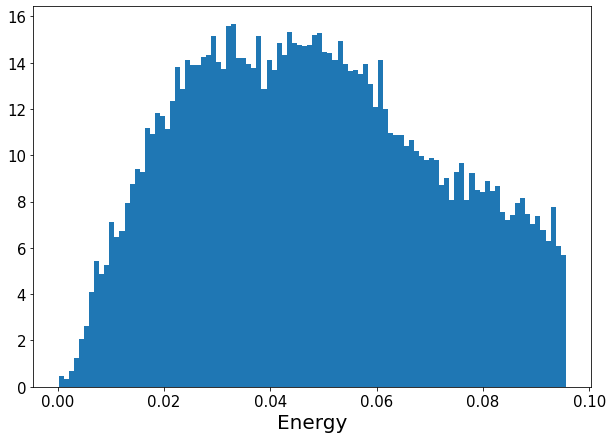

In [42]:
import matplotlib
import matplotlib.pylab as plt

plt.figure(figsize=(10,7))
plt.hist(data['Energy'],bins=100,density=True)
plt.xlabel('Energy',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## GPyTorch

In [45]:
import torch
import gpytorch

# from numpy to torch
Xtr = torch.from_numpy(Xtr)
ytr = torch.from_numpy(ytr)
Xtst = torch.from_numpy(Xtst)
ytst = torch.from_numpy(ytst)

Xtot = torch.from_numpy(Xtot)
ytot = torch.from_numpy(ytot)

In [46]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [47]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(Xtr, ytr, likelihood)

In [48]:
# Find optimal model hyperparameters using ADAM

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
mll_trajectory = []
mll_trajectory_tst = []
for i in range(training_iter):
    model.train()
    likelihood.train()
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(Xtr)
    # Calc loss and backprop gradients
    loss = -mll(output, ytr)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.6f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    print('lengthscale: ', model.covar_module.base_kernel.lengthscale[0])
    mll_trajectory.append(loss.item())
    optimizer.step()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        model.eval()
        likelihood.eval()
        ypred = likelihood(model(Xtst))
        mse = torch.sqrt(torch.sum((ypred.mean - ytst)**2))
        mll_trajectory_tst.append(mse)
        

Iter 1/100 - Loss: 0.773  noise: 0.693247
lengthscale:  tensor([0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931],
       grad_fn=<SelectBackward0>)
Iter 2/100 - Loss: 0.734  noise: 0.644497
lengthscale:  tensor([0.7444, 0.7444, 0.7444, 0.7444, 0.7444, 0.7444],
       grad_fn=<SelectBackward0>)
Iter 3/100 - Loss: 0.694  noise: 0.598213
lengthscale:  tensor([0.7978, 0.7978, 0.7978, 0.7978, 0.7978, 0.7978],
       grad_fn=<SelectBackward0>)
Iter 4/100 - Loss: 0.654  noise: 0.554367
lengthscale:  tensor([0.8532, 0.8532, 0.8530, 0.8532, 0.8530, 0.8530],
       grad_fn=<SelectBackward0>)
Iter 5/100 - Loss: 0.613  noise: 0.512924
lengthscale:  tensor([0.9101, 0.9102, 0.9098, 0.9101, 0.9099, 0.9098],
       grad_fn=<SelectBackward0>)
Iter 6/100 - Loss: 0.572  noise: 0.473837
lengthscale:  tensor([0.9685, 0.9685, 0.9679, 0.9685, 0.9680, 0.9678],
       grad_fn=<SelectBackward0>)
Iter 7/100 - Loss: 0.530  noise: 0.437057
lengthscale:  tensor([1.0278, 1.0278, 1.0269, 1.0278, 1.0271, 1.0268],
     

Text(0, 0.5, 'RMSE')

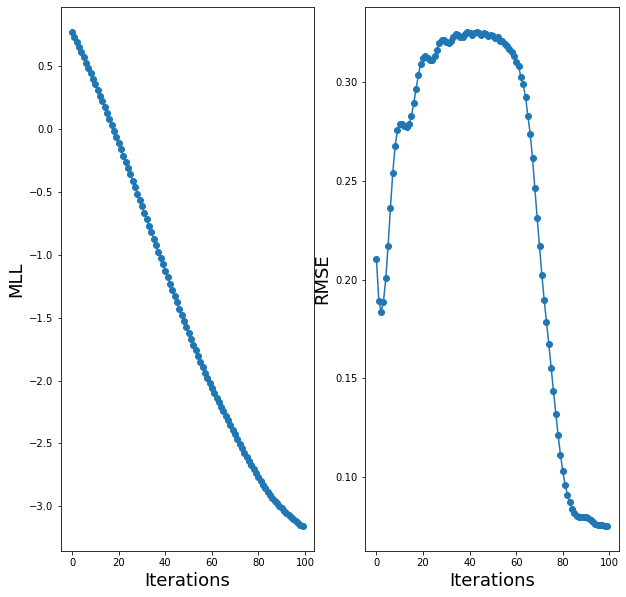

In [49]:
_,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
axs[0].plot(np.arange(training_iter), mll_trajectory,marker='o')
axs[1].plot(np.arange(training_iter), mll_trajectory_tst, marker='o')
axs[0].set_xlabel('Iterations',fontsize=18)
axs[0].set_ylabel('MLL',fontsize=18)
axs[1].set_xlabel('Iterations',fontsize=18)
axs[1].set_ylabel('RMSE', fontsize=18)


In [59]:
# Prediction with GPyTorch
from torch.utils.data import TensorDataset, DataLoader

# 	In all other cases, he suggests using a power of 2 as the mini-batch size.
# 	So the minibatch should be 64, 128, 256, 512, or 1024 elements large.

dummy_test_y = torch.full_like(Xtot, dtype=torch.long, fill_value=0)
test_dataset = TensorDataset(Xtot, dummy_test_y)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

means = torch.tensor([0.])
stds = torch.tensor([[0.,0]])
with torch.no_grad():
	for x_batch, _ in test_loader:
		preds = likelihood(model(x_batch.double()))
		mean = preds.mean #.cpu()
		means = torch.cat([means, mean])
		l,u = preds.confidence_region()
		std = torch.column_stack((l,u))
		stds = torch.vstack((stds,std))
        # stds = torch.vstack(stds,std)


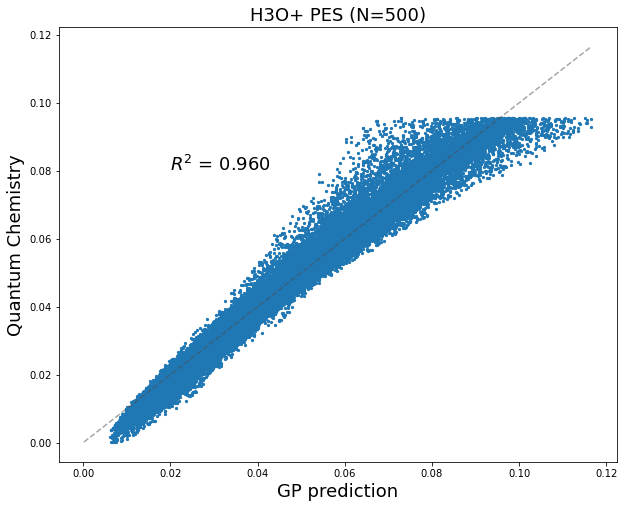

In [83]:
from sklearn.metrics import r2_score

ytot_gp = means[1:].numpy() # torch to numpy 
r2 = r2_score(ytot_gp,ytot)

plt.figure(figsize=(10,8))
plt.scatter(ytot_gp,ytot,s=5)

low = np.min(np.stack((ytot_gp,ytot)).flatten())
high = np.max(np.stack((ytot_gp,ytot)).flatten())
plt.plot([low, high], [low, high], ls="--", c=".5", alpha=0.5)

plt.title('H3O+ PES (N=%s)'%N,fontsize=18)
plt.text(0.02,0.08,r'$R^{2}$ = %.3f'%r2,fontsize=18)
plt.xlabel('GP prediction',fontsize=18)
plt.ylabel('Quantum Chemistry',fontsize=18)
plt.show()